# ATMS 523 Homework 5: Radar Parameter Rain Rate Prediction
## Stephen Allen
This notebook implements multiple machine learning models to predict rain rate from polarimetric radar parameters.



## 1. Import Libraries and Load Data



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)



In [3]:
# Load the dataset
df = pd.read_csv('radar_parameters.csv', index_col=0)
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()



Dataset shape: (18969, 7)

First few rows:


,Zh (dBZ),Zdr (dB),Ldr (dB),Kdp (deg km-1),Ah (dBZ/km),Adr (dB/km),R (mm/hr)
0,23.144878,0.418637,-41.757733,0.005395,0.000290,0.000012,2.393520
1,22.737156,0.322850,-43.772069,0.005194,0.000360,0.000012,3.502699
2,26.869826,0.330948,-43.577399,0.013385,0.000903,0.000030,8.627561
3,28.540561,0.399480,-42.139731,0.018872,0.001036,0.000043,8.424447
4,30.500127,0.543758,-39.763087,0.027438,0.001157,0.000064,8.189291


## Exploratory Data Analysis



In [4]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())
print(f"\nDataset info:")
df.info()



Missing values:
Zh (dBZ)          0
Zdr (dB)          0
Ldr (dB)          0
Kdp (deg km-1)    0
Ah (dBZ/km)       0
Adr (dB/km)       0
R (mm/hr)         0
dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 18969 entries, 0 to 18968
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Zh (dBZ)        18969 non-null  float64
 1   Zdr (dB)        18969 non-null  float64
 2   Ldr (dB)        18969 non-null  float64
 3   Kdp (deg km-1)  18969 non-null  float64
 4   Ah (dBZ/km)     18969 non-null  float64
 5   Adr (dB/km)     18969 non-null  float64
 6   R (mm/hr)       18969 non-null  float64
dtypes: float64(7)
memory usage: 1.2 MB


In [5]:
# Summary statistics
print("Summary Statistics:")
df.describe()



Summary Statistics:


,Zh (dBZ),Zdr (dB),Ldr (dB),Kdp (deg km-1),Ah (dBZ/km),Adr (dB/km),R (mm/hr)
count,18969.000000,18969.000000,18969.000000,18969.000000,18969.000000,18969.000000,18969.000000
mean,31.294021,0.762979,-37.969272,0.080879,0.001829,0.000234,7.855561
std,6.496330,0.363489,3.277391,0.221018,0.003469,0.000822,8.569413
min,14.036426,0.285207,-44.849249,0.000697,0.000044,0.000002,0.309399
25%,26.720145,0.489184,-40.573505,0.011537,0.000482,0.000027,3.072614
50%,31.020280,0.677804,-38.113140,0.028640,0.000977,0.000069,5.622457
75%,35.597165,0.947020,-35.601404,0.073099,0.001970,0.000182,9.622175
max,57.400639,3.843941,-25.373718,5.060710,0.082511,0.027538,195.557062


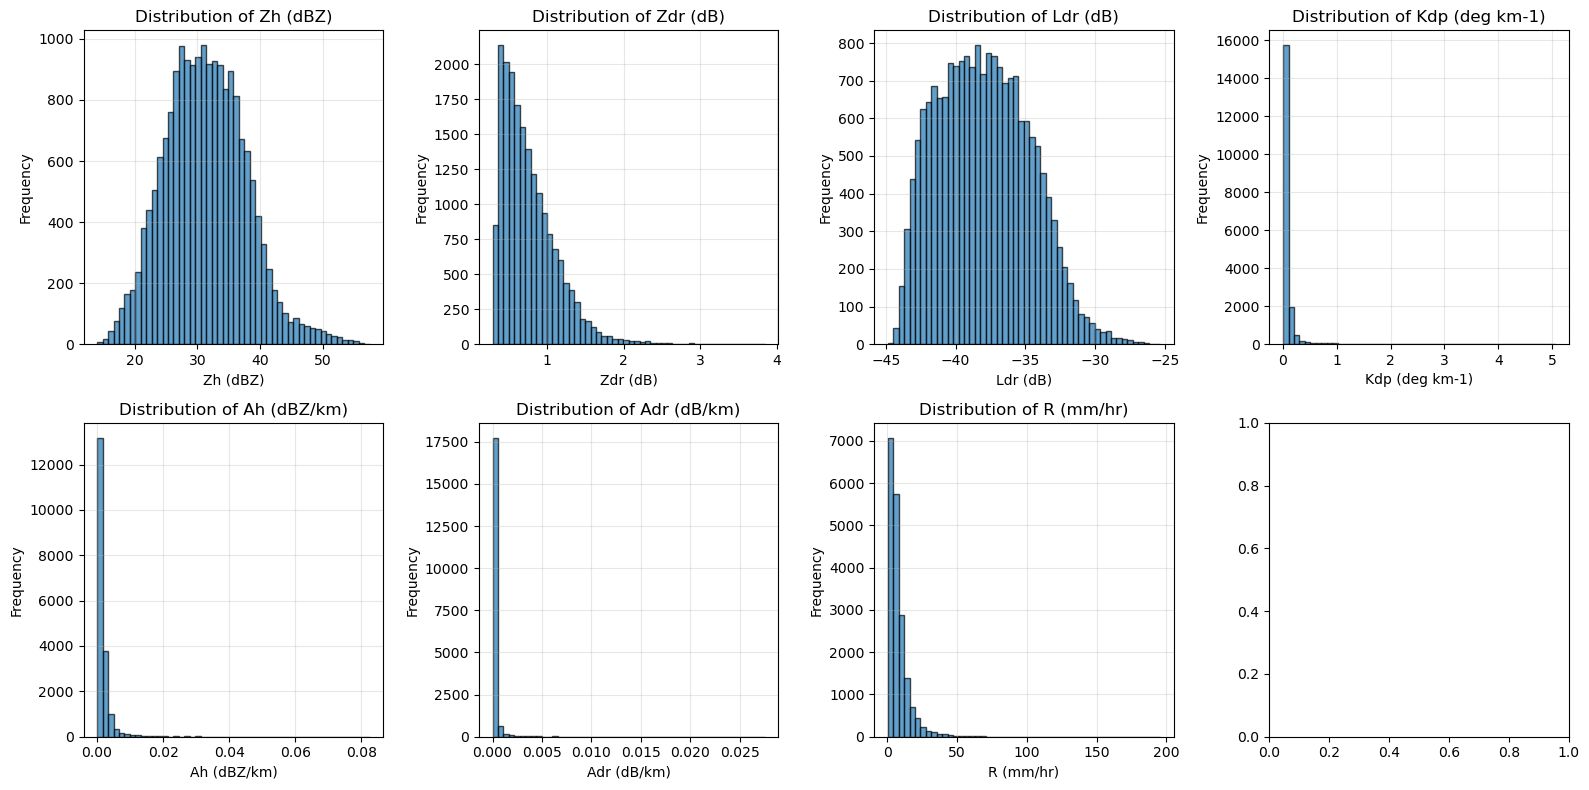

In [6]:
# Visualize distributions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, col in enumerate(df.columns):
    axes[idx].hist(df[col], bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()



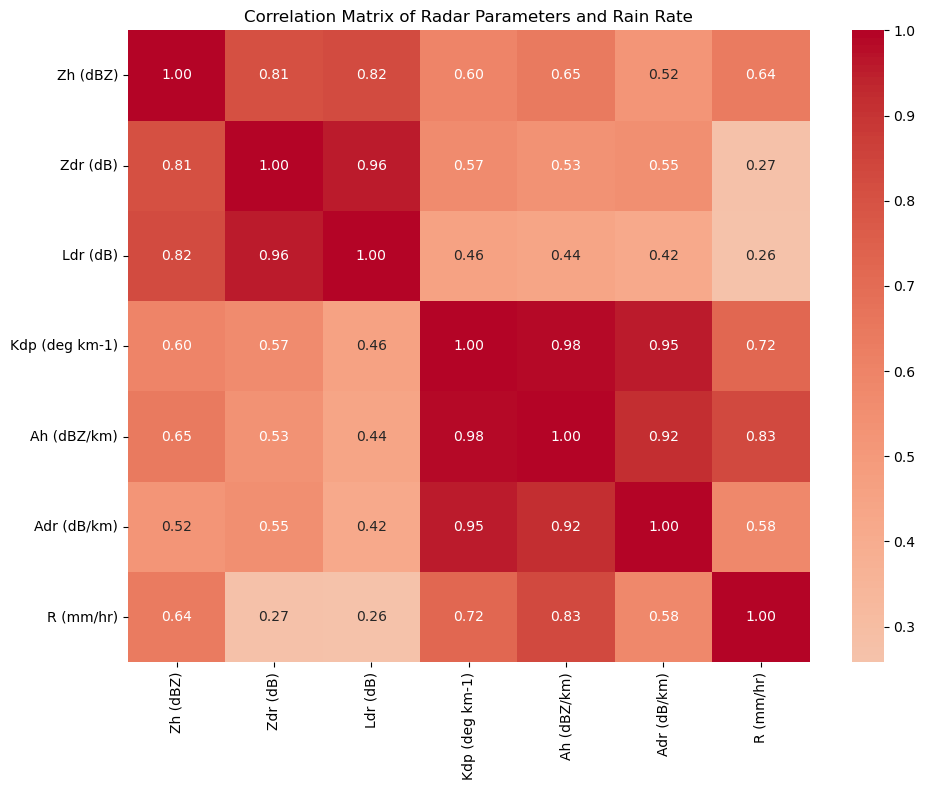

In [7]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Radar Parameters and Rain Rate')
plt.tight_layout()
plt.show()



## 2. Train-Test Split (70-30)



In [8]:
# Define features and target
feature_columns = ['Zh (dBZ)', 'Zdr (dB)', 'Ldr (dB)', 'Kdp (deg km-1)', 'Ah (dBZ/km)', 'Adr (dB/km)']
target_column = 'R (mm/hr)'

X = df[feature_columns]
y = df[target_column]

# Perform 70-30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"\nFeatures: {feature_columns}")
print(f"Target: {target_column}")



Training set size: 13278 samples
Testing set size: 5691 samples

Features: ['Zh (dBZ)', 'Zdr (dB)', 'Ldr (dB)', 'Kdp (deg km-1)', 'Ah (dBZ/km)', 'Adr (dB/km)']
Target: R (mm/hr)


## 3. Baseline Model: Z-R Relationship

The baseline uses the formula: $Z = 200R^{1.6}$

To predict R from Z, we rearrange: $R = (Z/200)^{1/1.6}$

where $Z = 10^{dBZ/10}$



In [9]:
def predict_rain_rate_from_zh(zh_dbz):
    """
    Predict rain rate using the Z-R relationship: Z = 200R^1.6
    
    Parameters:
    -----------
    zh_dbz : array-like
        Radar reflectivity in dBZ
    
    Returns:
    --------
    R : array-like
        Predicted rain rate in mm/hr
    """
    # Convert dBZ to linear Z
    Z = 10 ** (zh_dbz / 10)
    
    # Calculate R from Z = 200R^1.6
    # R = (Z/200)^(1/1.6)
    R = (Z / 200) ** (1 / 1.6)
    
    return R



In [10]:
# Make predictions using baseline model
y_train_pred_baseline = predict_rain_rate_from_zh(X_train['Zh (dBZ)'])
y_test_pred_baseline = predict_rain_rate_from_zh(X_test['Zh (dBZ)'])

# Calculate metrics
baseline_train_r2 = r2_score(y_train, y_train_pred_baseline)
baseline_test_r2 = r2_score(y_test, y_test_pred_baseline)
baseline_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_baseline))
baseline_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_baseline))

print("Baseline Model (Z-R Relationship) Performance:")
print("="*50)
print(f"Training R²: {baseline_train_r2:.4f}")
print(f"Testing R²: {baseline_test_r2:.4f}")
print(f"Training RMSE: {baseline_train_rmse:.4f} mm/hr")
print(f"Testing RMSE: {baseline_test_rmse:.4f} mm/hr")



Baseline Model (Z-R Relationship) Performance:
Training R²: 0.2756
Testing R²: 0.3566
Training RMSE: 7.1440 mm/hr
Testing RMSE: 7.1893 mm/hr


## 4. Multiple Linear Regression



In [11]:
# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Calculate metrics
lr_train_r2 = r2_score(y_train, y_train_pred_lr)
lr_test_r2 = r2_score(y_test, y_test_pred_lr)
lr_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))

print("Linear Regression Model Performance:")
print("="*50)
print(f"Training R²: {lr_train_r2:.4f}")
print(f"Testing R²: {lr_test_r2:.4f}")
print(f"Training RMSE: {lr_train_rmse:.4f} mm/hr")
print(f"Testing RMSE: {lr_test_rmse:.4f} mm/hr")

print("\nModel Coefficients:")
for feature, coef in zip(feature_columns, lr_model.coef_):
    print(f"{feature}: {coef:.6f}")
print(f"Intercept: {lr_model.intercept_:.6f}")



Linear Regression Model Performance:
Training R²: 0.9879
Testing R²: 0.9891
Training RMSE: 0.9229 mm/hr
Testing RMSE: 0.9358 mm/hr

Model Coefficients:
Zh (dBZ): 0.159902
Zdr (dB): 2.026910
Ldr (dB): -0.618193
Kdp (deg km-1): -71.046037
Ah (dBZ/km): 7778.923885
Adr (dB/km): -6122.080711
Intercept: -29.221095


## 5. Polynomial Regression with Grid Search
Grid search over polynomial orders 0-9 with 7-fold cross-validation



In [12]:
# Create pipeline for polynomial regression
poly_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures()),
    ('linear_regression', LinearRegression())
])

# Define parameter grid
param_grid_poly = {
    'poly_features__degree': list(range(0, 10))  # 0-9
}

# Perform grid search with 7-fold cross-validation
print("Performing grid search for polynomial regression...")
print("This may take a few minutes...")

grid_search_poly = GridSearchCV(
    poly_pipeline,
    param_grid_poly,
    cv=7,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_poly.fit(X_train, y_train)

print("\nGrid search complete!")
print(f"Best polynomial degree: {grid_search_poly.best_params_['poly_features__degree']}")
print(f"Best cross-validation R²: {grid_search_poly.best_score_:.4f}")



Performing grid search for polynomial regression...
This may take a few minutes...
Fitting 7 folds for each of 10 candidates, totalling 70 fits

Grid search complete!
Best polynomial degree: 8
Best cross-validation R²: 0.9999


In [13]:
# Display all cross-validation results
cv_results_poly = pd.DataFrame(grid_search_poly.cv_results_)
print("\nCross-validation results for all polynomial orders:")
print(cv_results_poly[['param_poly_features__degree', 'mean_test_score', 'std_test_score']].to_string(index=False))




Cross-validation results for all polynomial orders:
 param_poly_features__degree  mean_test_score  std_test_score
                           0        -0.000779        0.001018
                           1         0.985456        0.005212
                           2         0.996999        0.006237
                           3         0.991524        0.020729
                           4         0.988007        0.028735
                           5         0.998869        0.002644
                           6         0.997642        0.005726
                           7         0.999300        0.001536
                           8         0.999942        0.000106
                           9         0.999900        0.000198


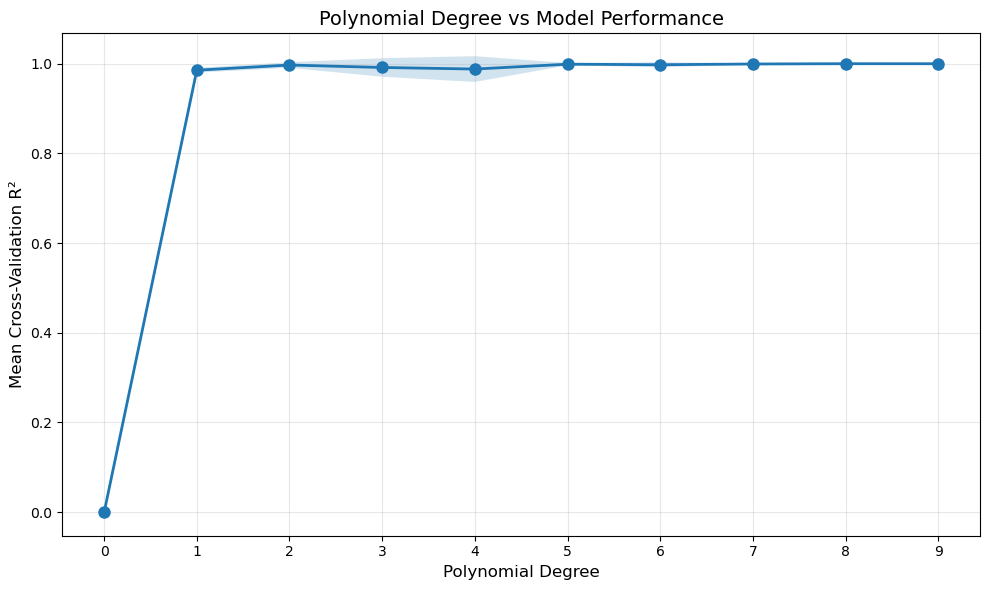

In [14]:
# Visualize polynomial degree vs R²
plt.figure(figsize=(10, 6))
plt.plot(cv_results_poly['param_poly_features__degree'], 
         cv_results_poly['mean_test_score'], 
         marker='o', linestyle='-', linewidth=2, markersize=8)
plt.fill_between(cv_results_poly['param_poly_features__degree'],
                 cv_results_poly['mean_test_score'] - cv_results_poly['std_test_score'],
                 cv_results_poly['mean_test_score'] + cv_results_poly['std_test_score'],
                 alpha=0.2)
plt.xlabel('Polynomial Degree', fontsize=12)
plt.ylabel('Mean Cross-Validation R²', fontsize=12)
plt.title('Polynomial Degree vs Model Performance', fontsize=14)
plt.grid(alpha=0.3)
plt.xticks(range(0, 10))
plt.tight_layout()
plt.show()



In [15]:
# Get the best model and make predictions
best_poly_model = grid_search_poly.best_estimator_
y_train_pred_poly = best_poly_model.predict(X_train)
y_test_pred_poly = best_poly_model.predict(X_test)

# Calculate metrics
poly_train_r2 = r2_score(y_train, y_train_pred_poly)
poly_test_r2 = r2_score(y_test, y_test_pred_poly)
poly_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
poly_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_poly))

print(f"Best Polynomial Regression Model (degree={grid_search_poly.best_params_['poly_features__degree']}) Performance:")
print("="*50)
print(f"Training R²: {poly_train_r2:.4f}")
print(f"Testing R²: {poly_test_r2:.4f}")
print(f"Training RMSE: {poly_train_rmse:.4f} mm/hr")

print(f"Testing RMSE: {poly_test_rmse:.4f} mm/hr")



Best Polynomial Regression Model (degree=8) Performance:
Training R²: 1.0000
Testing R²: 1.0000
Training RMSE: 0.0050 mm/hr
Testing RMSE: 0.0073 mm/hr


## 6. Random Forest Regressor with Grid Search
Grid search over specified hyperparameters with cross-validation.
**Note**: This will be computationally intensive and may take several minutes to complete.



In [16]:
# Define parameter grid for Random Forest
param_grid_rf = {
    "bootstrap": [True, False],
    "max_depth": [10, 100],
    "max_features": ["sqrt", 1.0],
    "min_samples_leaf": [1, 4],
    "min_samples_split": [2, 10],
    "n_estimators": [200, 1000]
}

# Calculate total number of combinations
total_combinations = np.prod([len(v) for v in param_grid_rf.values()])
print(f"Total parameter combinations to test: {total_combinations}")
print("\nPerforming grid search for Random Forest...")
print("This will take several minutes. Progress will be displayed...")
print("="*70)



Total parameter combinations to test: 64

Performing grid search for Random Forest...
This will take several minutes. Progress will be displayed...


In [17]:
# Perform grid search with cross-validation
rf_base = RandomForestRegressor(random_state=42)

grid_search_rf = GridSearchCV(
    rf_base,
    param_grid_rf,
    cv=7,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search_rf.fit(X_train, y_train)

print("\nGrid search complete!")
print("\nBest parameters found:")
for param, value in grid_search_rf.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation R²: {grid_search_rf.best_score_:.4f}")



Fitting 7 folds for each of 64 candidates, totalling 448 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total

In [18]:
# Get the best model and make predictions
best_rf_model = grid_search_rf.best_estimator_
y_train_pred_rf = best_rf_model.predict(X_train)
y_test_pred_rf = best_rf_model.predict(X_test)

# Calculate metrics
rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_test_r2 = r2_score(y_test, y_test_pred_rf)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

print("Best Random Forest Model Performance:")
print("="*50)
print(f"Training R²: {rf_train_r2:.4f}")
print(f"Testing R²: {rf_test_r2:.4f}")
print(f"Training RMSE: {rf_train_rmse:.4f} mm/hr")
print(f"Testing RMSE: {rf_test_rmse:.4f} mm/hr")



Best Random Forest Model Performance:
Training R²: 0.9974
Testing R²: 0.9879
Training RMSE: 0.4255 mm/hr
Testing RMSE: 0.9843 mm/hr



Feature Importance from Random Forest:
       Feature  Importance
   Ah (dBZ/km)    0.812550
      Zdr (dB)    0.121522
      Ldr (dB)    0.050305
Kdp (deg km-1)    0.007441
      Zh (dBZ)    0.004256
   Adr (dB/km)    0.003925


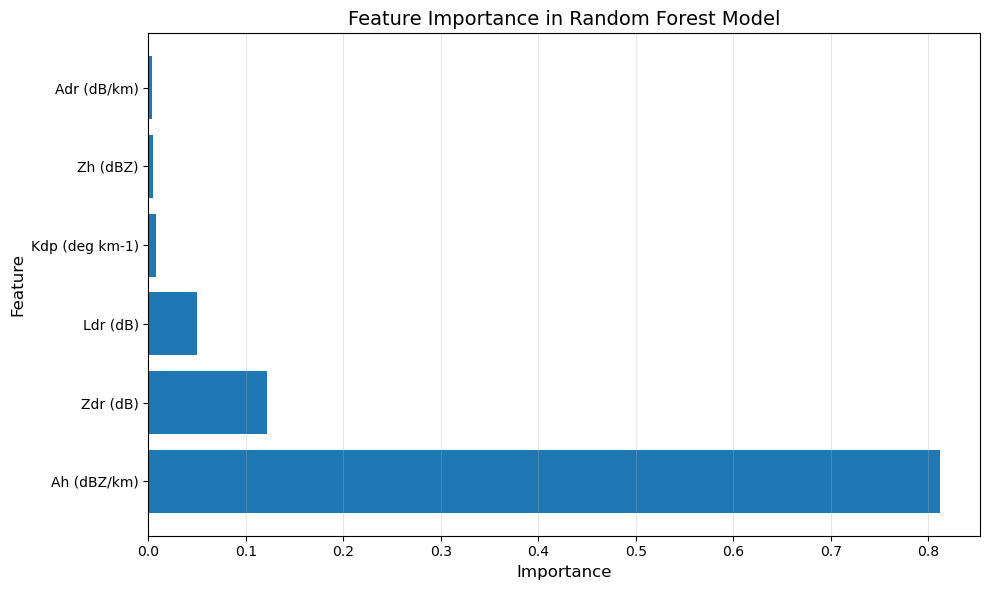

In [19]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance from Random Forest:")
print(feature_importance.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance in Random Forest Model', fontsize=14)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()



## 7. Model Comparison and Results Summary



In [20]:
# Create comparison table
results_df = pd.DataFrame({
    'Model': [
        'Baseline (Z-R)',
        'Linear Regression',
        f'Polynomial (degree={grid_search_poly.best_params_["poly_features__degree"]})',
        'Random Forest'
    ],
    'Train R²': [
        baseline_train_r2,
        lr_train_r2,
        poly_train_r2,
        rf_train_r2
    ],
    'Test R²': [
        baseline_test_r2,
        lr_test_r2,
        poly_test_r2,
        rf_test_r2
    ],
    'Train RMSE': [
        baseline_train_rmse,
        lr_train_rmse,
        poly_train_rmse,
        rf_train_rmse
    ],
    'Test RMSE': [
        baseline_test_rmse,
        lr_test_rmse,
        poly_test_rmse,
        rf_test_rmse
    ]
})

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)




MODEL COMPARISON SUMMARY
                Model  Train R²  Test R²  Train RMSE  Test RMSE
       Baseline (Z-R)  0.275551 0.356643    7.143950   7.189316
    Linear Regression  0.987909 0.989099    0.922940   0.935812
Polynomial (degree=8)  1.000000 0.999999    0.005010   0.007305
        Random Forest  0.997431 0.987940    0.425453   0.984304


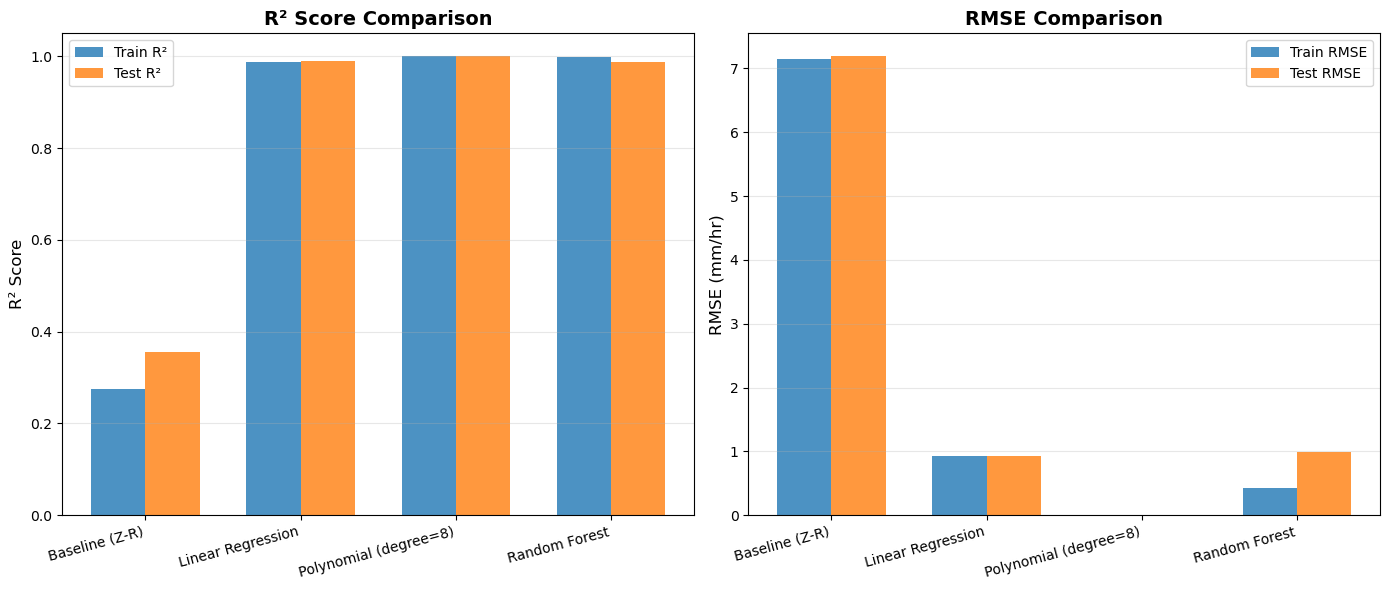

In [21]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# R² comparison
x_pos = np.arange(len(results_df))
width = 0.35

axes[0].bar(x_pos - width/2, results_df['Train R²'], width, label='Train R²', alpha=0.8)
axes[0].bar(x_pos + width/2, results_df['Test R²'], width, label='Test R²', alpha=0.8)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_df['Model'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# RMSE comparison
axes[1].bar(x_pos - width/2, results_df['Train RMSE'], width, label='Train RMSE', alpha=0.8)
axes[1].bar(x_pos + width/2, results_df['Test RMSE'], width, label='Test RMSE', alpha=0.8)
axes[1].set_ylabel('RMSE (mm/hr)', fontsize=12)
axes[1].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results_df['Model'], rotation=15, ha='right')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



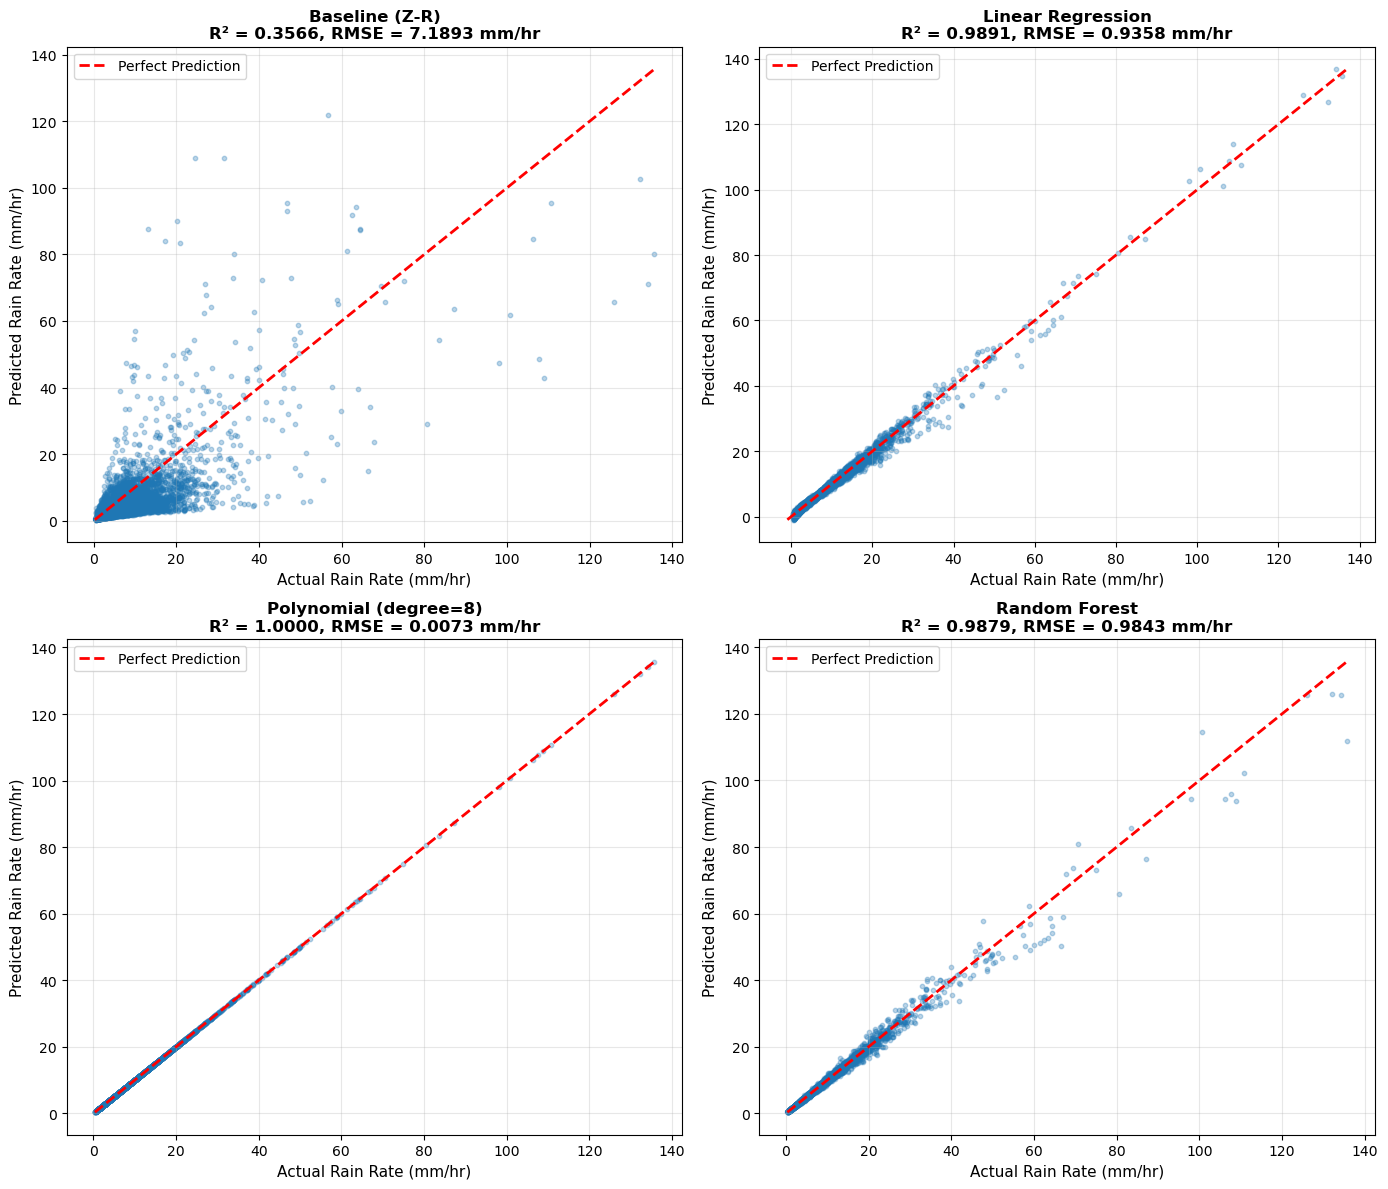

In [22]:
# Predicted vs Actual plots for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

predictions = [
    (y_test_pred_baseline, 'Baseline (Z-R)', baseline_test_r2, baseline_test_rmse),
    (y_test_pred_lr, 'Linear Regression', lr_test_r2, lr_test_rmse),
    (y_test_pred_poly, f'Polynomial (degree={grid_search_poly.best_params_["poly_features__degree"]})', poly_test_r2, poly_test_rmse),
    (y_test_pred_rf, 'Random Forest', rf_test_r2, rf_test_rmse)
]

for idx, (y_pred, model_name, r2, rmse) in enumerate(predictions):
    axes[idx].scatter(y_test, y_pred, alpha=0.3, s=10)
    
    # Add perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    axes[idx].set_xlabel('Actual Rain Rate (mm/hr)', fontsize=11)
    axes[idx].set_ylabel('Predicted Rain Rate (mm/hr)', fontsize=11)
    axes[idx].set_title(f'{model_name}\nR² = {r2:.4f}, RMSE = {rmse:.4f} mm/hr', fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()



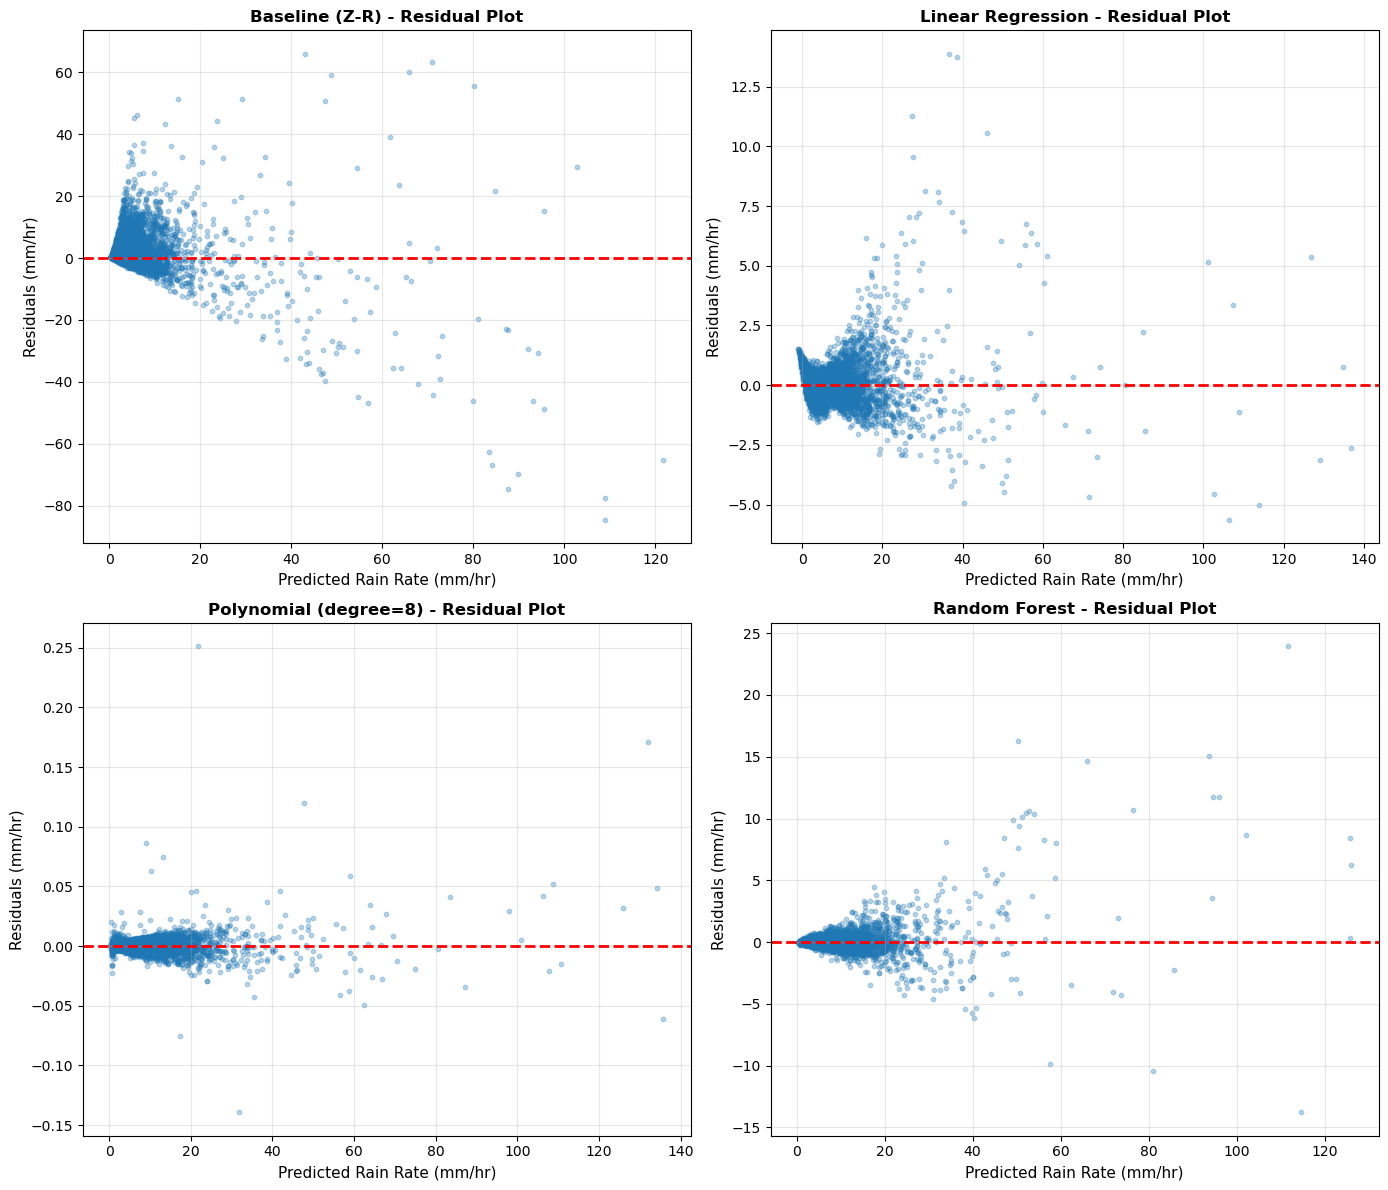

In [23]:
# Residual plots for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (y_pred, model_name, r2, rmse) in enumerate(predictions):
    residuals = y_test - y_pred
    
    axes[idx].scatter(y_pred, residuals, alpha=0.3, s=10)
    axes[idx].axhline(y=0, color='r', linestyle='--', linewidth=2)
    
    axes[idx].set_xlabel('Predicted Rain Rate (mm/hr)', fontsize=11)
    axes[idx].set_ylabel('Residuals (mm/hr)', fontsize=11)
    axes[idx].set_title(f'{model_name} - Residual Plot', fontsize=12, fontweight='bold')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()



## Discussion

After running all the models, analyze your results by answering the following questions:

### Question 2: Linear Regression vs Baseline
Compare R² and RMSE between linear regression and baseline models. Does using all 6 radar parameters improve predictions over just using Zh?

### Question 3: Polynomial Regression
What polynomial degree performed best? Does it beat the baseline and linear models? Is there overfitting (train vs test performance)?

### Question 4: Random Forest
What hyperparameters were optimal? Which features were most important? Does Random Forest perform best?

### Overall Conclusion
Which model is best for predicting rain rate from radar parameters?

